<a href="https://colab.research.google.com/github/Snehal-Reddy/NeuralNetPruning/blob/master/UnitAndWeightBasedPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
tf.enable_eager_execution()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


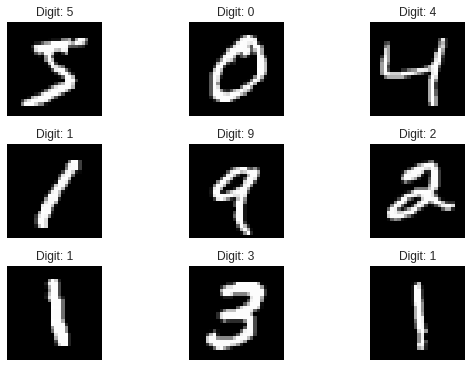

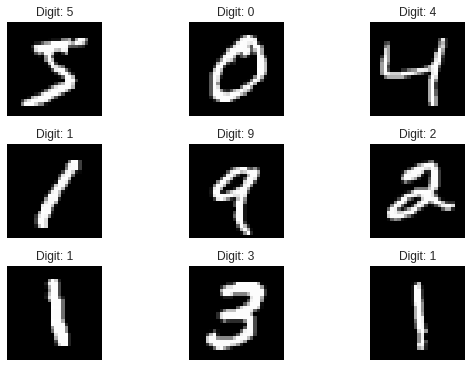

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# features, labels = next(iter(mnist))

fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [0]:
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

In [4]:
naive_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def loss(naive_model, x, y):
    y_ = naive_model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [0]:
def grad(naive_model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(naive_model, inputs, targets)
    return loss_value, tape.gradient(loss_value, naive_model.trainable_variables)

In [0]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

In [8]:
from tensorflow import contrib
tfe = contrib.eager

train_loss_results = []
train_accuracy_results = []

epoch_num = 5

for epoch in range(epoch_num):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    for x, y in (dataset_train):
        outputs = naive_model(x)
        loss_value, grads = grad(naive_model, x, y)
        optimizer.apply_gradients(zip(grads, naive_model.trainable_variables),global_step)  
        
        epoch_loss_avg(loss_value)  
#         epoch_accuracy(tf.argmax(naive_model(x), axis=1, output_type=tf.int32), y)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Epoch 000: Loss: 0.199, Accuracy: 94.003%


In [0]:
 def test(model, data_test):  
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    for x, y in dataset_test:
        outputs = model(x)
        loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    result = epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()
    return result


In [0]:
import time
list_percentile = [0,1,5,10,15,25,50,80,95]


In [0]:
class NewModel():
    def __init__(self, sparsify=True):
        self.sparsify = sparsify
        self.flatten = tf.layers.Flatten()
        self.weights = []
        
    def add_layer(self, weights):
        if self.sparsify:
            weights = tf.contrib.layers.dense_to_sparse(weights)
        self.weights.append(weights)
        
    def __call__(self, dense_x):
        dense_x = self.flatten(dense_x)
        if self.sparsify:
            dense_x = tf.transpose(dense_x) 
        for i, weights in enumerate(self.weights):
            if self.sparsify:
                dense_x = tf.sparse.matmul(weights, dense_x, adjoint_a=True) 
            else:
                dense_x = tf.matmul(dense_x, weights)
            if i < len(self.weights)-1:
                dense_x = tf.nn.relu(dense_x)
        if self.sparsify:
            dense_x = tf.transpose(dense_x) # X == (X^T)^T
        return dense_x


In [0]:
def weights_zero(model, percentile, sparsify=True):
    new_model = NewModel(sparsify)

    for num_layer, weights in enumerate(model.trainable_weights):
        weights_np = weights.numpy()
        if num_layer < len(model.trainable_weights)-1:
            all_greater = np.abs(weights_np) < np.percentile(np.abs(weights_np), percentile)
            weights_np[all_greater] = 0

        new_model.add_layer(tf.convert_to_tensor(weights_np))

    return new_model

In [28]:
test_losses = []
test_accuracies = []
sparse_timings = []
timings = []

for percentile in list_percentile:
    sparsified_model = weights_zero(naive_model, percentile, True)
    start_time_1 = time.clock()
    l, a = test(sparsified_model, dataset_test)
    end_time_1 = time.clock()

    pruned_model = weights_zero(naive_model, percentile, False)
    start_time_2 = time.clock()
    l2, a2 = test(pruned_model, dataset_test)
    end_time_2 = time.clock()
    
    np.testing.assert_almost_equal(l, l2)
    np.testing.assert_almost_equal(a, a2)
    
    print(f"{percentile} -> Loss: {l:.4f},  Accuracy: {a:.4f}, Sparse Time {end_time_1-start_time_1:.2f}s, Prune Time {end_time_2-start_time_2:.2f}s)")
    test_losses.append(l)
    test_accuracies.append(a)
    sparse_timings.append(end_time_1-start_time_1)
    timings.append(end_time_2-start_time_2)

0 -> Loss: 0.0931,  Accuracy: 0.9730, Sparse Time 33.95s, Prune Time 2.91s)
1 -> Loss: 0.0931,  Accuracy: 0.9730, Sparse Time 33.61s, Prune Time 2.93s)
5 -> Loss: 0.0932,  Accuracy: 0.9729, Sparse Time 32.26s, Prune Time 2.94s)
10 -> Loss: 0.0930,  Accuracy: 0.9731, Sparse Time 30.60s, Prune Time 2.92s)
15 -> Loss: 0.0931,  Accuracy: 0.9732, Sparse Time 28.99s, Prune Time 2.84s)
25 -> Loss: 0.0916,  Accuracy: 0.9731, Sparse Time 25.65s, Prune Time 2.94s)
50 -> Loss: 0.0838,  Accuracy: 0.9754, Sparse Time 17.41s, Prune Time 2.88s)
80 -> Loss: 0.2835,  Accuracy: 0.9726, Sparse Time 7.45s, Prune Time 2.94s)
95 -> Loss: 2.0756,  Accuracy: 0.8624, Sparse Time 2.45s, Prune Time 3.10s)


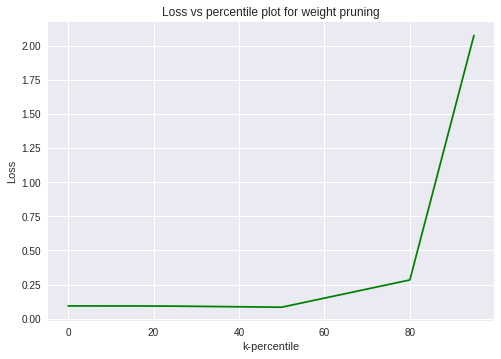

In [29]:
plt.plot(list_percentile, test_losses, color='g')
plt.xlabel('k-percentile')
plt.ylabel('Loss')
plt.title('Loss vs percentile plot for weight pruning')
plt.show()

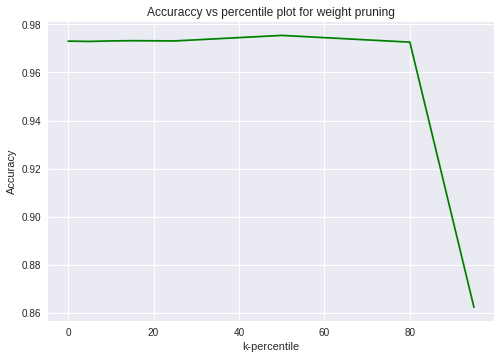

In [30]:
plt.plot(list_percentile, test_accuracies, color='g')
plt.xlabel('k-percentile')
plt.ylabel('Accuracy')
plt.title('Accuraccy vs percentile plot for weight pruning')
plt.show()

In [0]:
###########################################################################################################################################

In [0]:
def neuron_prune(model, percentile):
    new_model = Sequential()
    new_model.add(Flatten(input_shape=(28, 28)))
    cols_prev = None

    for layer_num, weights in enumerate(model.trainable_weights):
        wts_np = weights.numpy()
        if layer_num < len(model.trainable_weights)-1: # Do not prune last layer
            min_val = np.percentile(np.linalg.norm(wts_np, ord=2, axis=0), percentile)
            all_greater = np.linalg.norm(wts_np, ord=2, axis=0) >= min_val
            wts_np = wts_np[:, all_greater]
            
        if cols_prev is not None:
            wts_np = wts_np[cols_prev, :]
        
        if layer_num < len(model.trainable_weights)-1: 
            cols_prev = np.argwhere(all_greater).reshape(-1)

        new_layer = tf.keras.layers.Dense(wts_np.shape[1], activation=tf.nn.relu, use_bias=False)
        new_model.add(new_layer)
        new_layer.set_weights([wts_np])

    return new_model


In [32]:
neuron_test_losses = []
neuron_test_accuracies = []
unit_timings = []

for percentile in list_percentile:
    sparse_model = neuron_prune(naive_model, percentile)
    start_t = time.clock()
    loss, acc = test(sparse_model, dataset_test)
    end_t = time.clock()
    print(f"{percentile} ->  Loss: {loss:.4f},  Accuracy: {acc:.4f}, Timing: {start_t - end_t:.2f}s")
    neuron_test_losses.append(loss)
    neuron_test_accuracies.append(acc)
    unit_timings.append(start_t - end_t)

0 ->  Loss: 0.0950,  Accuracy: 0.9730, Timing: -3.00s
1 ->  Loss: 0.0950,  Accuracy: 0.9730, Timing: -3.42s
5 ->  Loss: 0.0948,  Accuracy: 0.9731, Timing: -3.19s
10 ->  Loss: 0.0949,  Accuracy: 0.9731, Timing: -3.05s
15 ->  Loss: 0.0937,  Accuracy: 0.9730, Timing: -2.86s
25 ->  Loss: 0.0915,  Accuracy: 0.9736, Timing: -2.52s
50 ->  Loss: 0.2258,  Accuracy: 0.9686, Timing: -1.55s
80 ->  Loss: 2.0074,  Accuracy: 0.7042, Timing: -1.04s
95 ->  Loss: 2.3023,  Accuracy: 0.1378, Timing: -0.65s


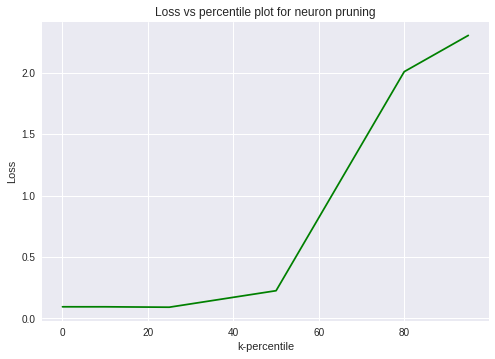

In [33]:
plt.plot(list_percentile, neuron_test_losses, color='g')
plt.xlabel('k-percentile')
plt.ylabel('Loss')
plt.title('Loss vs percentile plot for neuron pruning')
plt.show()

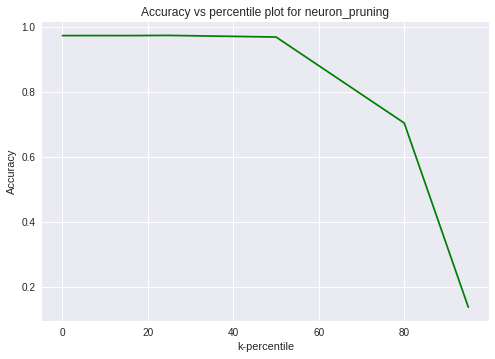

In [34]:
plt.plot(list_percentile, neuron_test_accuracies, color='g')
plt.xlabel('k-percentile')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentile plot for neuron_pruning')
plt.show()

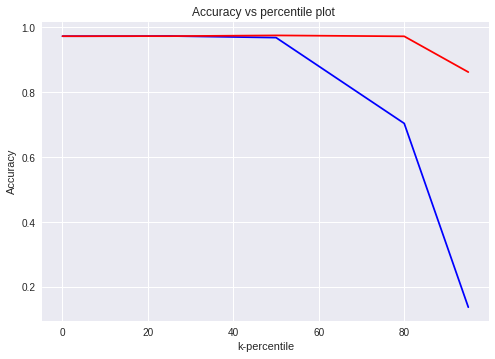

In [39]:
plt.plot(list_percentile, neuron_test_accuracies, color='b', label = 'neuron pruning')
plt.plot(list_percentile, test_accuracies, color='r', label = 'weight pruning')
plt.xlabel('k-percentile')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentile plot ')
plt.show()

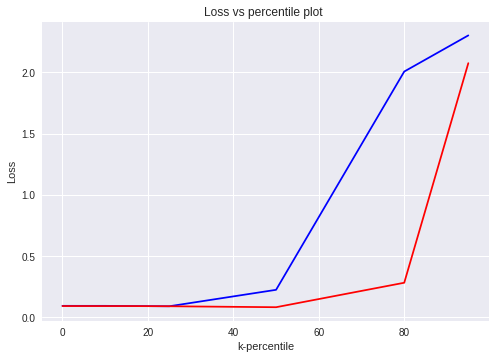

In [38]:
plt.plot(list_percentile, neuron_test_losses, color='b', label = 'neuron pruning')
plt.plot(list_percentile, test_losses, color='r', label = 'weight pruning')
plt.xlabel('k-percentile')
plt.ylabel('Loss')
plt.title('Loss vs percentile plot ')
plt.show()